# TP2 Álgebra Lineal Computacional

## Procesamiento de datos

1. Cargo el archivo "Tabla nutricional", lleno los datos nulos con 0 y modifico los valores para que todos estén en la misma unidad de medida (gr)

In [1]:
#Leo el archivo
import pandas as pd

df = pd.read_csv("tabla_nutricional.csv", encoding='latin_1',delimiter=';')

consumidores_libres = pd.read_csv("consumidores_libres.csv", encoding='latin_1',delimiter=';')

In [2]:
#Completo con ceros
tn = df.fillna(0)
tn.head()

,Alimento,Cantidad (gr/ml),HC (gr),Proteinas (gr),Grasas (gr),Na (mg),Ca (mg),Fe (mg),Azucares Libres (gr),AGS (gr),AGNI (gr),AG p (gr),Fibra (gr)
0,Leche fluida entera,270.00,12.42,8.37,7.83,153.90,283.50,0.189,0.0,4.99,2.19,0.520,0.0
1,Leche entera en polvo,11.00,4.51,2.84,2.73,44.44,99.00,0.060,0.0,1.62,0.77,0.060,0.0
2,Yogurt,19.00,2.45,0.51,0.49,7.99,17.67,0.005,0.0,0.32,0.14,0.014,0.0
3,Queso crema,1.66,0.06,0.10,0.37,1.23,0.93,0.000,0.0,0.36,0.11,0.010,0.0
4,Queso cuartirolo,3.66,0.06,0.77,0.80,20.84,16.54,0.000,0.0,0.76,0.21,0.020,0.0


In [3]:
#Cambio todas las unidades de medida a gr
nuevosNombres = {}
for col in tn.columns:
    if "mg" in col:
        tn[col] = tn[col]/1000
    nuevosNombres[col] = col.replace('mg','gr')
tn = tn.rename(columns=nuevosNombres)
tn.head()

,Alimento,Cantidad (gr/ml),HC (gr),Proteinas (gr),Grasas (gr),Na (gr),Ca (gr),Fe (gr),Azucares Libres (gr),AGS (gr),AGNI (gr),AG p (gr),Fibra (gr)
0,Leche fluida entera,270.00,12.42,8.37,7.83,0.15390,0.28350,0.000189,0.0,4.99,2.19,0.520,0.0
1,Leche entera en polvo,11.00,4.51,2.84,2.73,0.04444,0.09900,0.000060,0.0,1.62,0.77,0.060,0.0
2,Yogurt,19.00,2.45,0.51,0.49,0.00799,0.01767,0.000005,0.0,0.32,0.14,0.014,0.0
3,Queso crema,1.66,0.06,0.10,0.37,0.00123,0.00093,0.000000,0.0,0.36,0.11,0.010,0.0
4,Queso cuartirolo,3.66,0.06,0.77,0.80,0.02084,0.01654,0.000000,0.0,0.76,0.21,0.020,0.0


In [4]:
def cumpleMargen(data):
    cantidad = data[data.columns[1]].sum()
    proteinas = data[data.columns[3]].sum()
    grasas = data[data.columns[4]].sum()
    carbohidratos = data[data.columns[2]].sum()
    
    # 'dCELGA PAQUETE',
    # 'NARANJA',
    # 'MANZANA',
    # 'BOLA DE LOMO',
    # 'ASADO',
    # 'PALETA',
    # 'CARNE PICADA COMUN'

    sodio = data[data.columns[5]].sum()
        
    frutasYverduras = data.loc[data['Alimento'].isin(["Acelga","Zanahoria","Tomate","Lechuga","Cebolla","Zapallo","Manzana","Naranja","Mandarina","pera","Banana","Papa","Batata","Tomate envasado"])]
    frutVer = frutasYverduras[frutasYverduras.columns[1]].sum()

    fibras = data[data.columns[12]].sum()
    
    res = True
    if (grasas < cantidad * 0.15) or (grasas > cantidad * 0.30):
        res = False
    elif (carbohidratos < cantidad * 0.55) or (carbohidratos > cantidad * 0.75):
        res = False
    elif(proteinas < cantidad * 0.10) or (proteinas > cantidad * 0.15):
        res = False
    elif (sodio < 200):
        res = False
    elif (fibras < 25):
        res = False
    elif (frutVer < 400):
        res = False
    return res

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Modifico la tabla para que me muestre los nutrientes por gramo
cantidades = tn[tn.columns[1]]
tn0 = tn.copy()
for i in range(tn.shape[0]):
    tn0.iloc[i,1:] = tn0.iloc[i,1:]/cantidades[i]

#Divido la tabla por tipo de alimento

FV = ["Acelga","Zanahoria","Tomate","Lechuga","Cebolla","Zapallo","Manzana","Naranja","Mandarina","pera","Banana","Papa","Batata","Tomate envasado"]
Proteinas = tn0[tn0["Proteinas (gr)"]>0.2]["Alimento"]
SinProteinas = tn0[tn0["Proteinas (gr)"]==0]["Alimento"]
Grasos = tn0[tn0["Grasas (gr)"]>0.2]["Alimento"]

tnFV = tn0.loc[tn0['Alimento'].isin(FV)]
tnProt = tn0.loc[tn0['Alimento'].isin(Proteinas)]
tnSinProt = tn0.loc[tn0['Alimento'].isin(SinProteinas)]
tnGrasos = tn0.loc[tn0['Alimento'].isin(Grasos)]



tnResto = tn0.loc[~tn0['Alimento'].isin(Grasos)]
print(tnGrasos.shape,tnResto.shape)
tnProt


(8, 13) (49, 13)


,Alimento,Cantidad (gr/ml),HC (gr),Proteinas (gr),Grasas (gr),Na (gr),Ca (gr),Fe (gr),Azucares Libres (gr),AGS (gr),AGNI (gr),AG p (gr),Fibra (gr)
1,Leche entera en polvo,1.0,0.410000,0.258182,0.248182,0.004040,0.009000,0.000005,0.0,0.147273,0.070000,0.005455,0.0
4,Queso cuartirolo,1.0,0.016393,0.210383,0.218579,0.005694,0.004519,0.000000,0.0,0.207650,0.057377,0.005464,0.0
5,Queso rallar,1.0,0.036145,0.331325,0.271084,0.012301,0.009506,0.000000,0.0,0.216867,0.066265,0.004819,0.0
11,Bola de Lomo,1.0,0.000000,0.212059,0.014118,0.000630,0.000030,0.000035,0.0,0.058529,0.064706,0.003824,0.0
13,pollo,1.0,0.000000,0.210000,0.037937,0.000730,0.000120,0.000016,0.0,0.029683,0.043175,0.022698,0.0


In [7]:
#
tnMedias = np.mean(tn0.iloc[:,2:], axis=0)

tnCentrado = tn0.iloc[:,2:]
for i in range(tnCentrado.shape[1]):
    tnCentrado[tnCentrado.columns[i]] = tnCentrado[tnCentrado.columns[i]] - tnMedias[i]

# 
tnRestoCentrado = tnResto.iloc[:,2:]
for i in range(tnRestoCentrado.shape[1]):
    tnRestoCentrado[tnRestoCentrado.columns[i]] = tnRestoCentrado[tnRestoCentrado.columns[i]] - tnMedias[i]

tnFVCentrado = tnFV.iloc[:,2:]
for i in range(tnFVCentrado.shape[1]):
    tnFVCentrado[tnFVCentrado.columns[i]] = tnFVCentrado[tnFVCentrado.columns[i]] - tnMedias[i]
    
tnProtCentrado = tnProt.iloc[:,2:]
for i in range(tnProtCentrado.shape[1]):
    tnProtCentrado[tnProtCentrado.columns[i]] = tnProtCentrado[tnProtCentrado.columns[i]] - tnMedias[i]

tnSinProtCentrado = tnSinProt.iloc[:,2:]
for i in range(tnSinProtCentrado.shape[1]):
    tnSinProtCentrado[tnSinProtCentrado.columns[i]] = tnSinProtCentrado[tnSinProtCentrado.columns[i]] - tnMedias[i]

tnGrasosCentrado = tnGrasos.iloc[:,2:]
for i in range(tnGrasosCentrado.shape[1]):
    tnGrasosCentrado[tnGrasosCentrado.columns[i]] = tnGrasosCentrado[tnGrasosCentrado.columns[i]] - tnMedias[i]

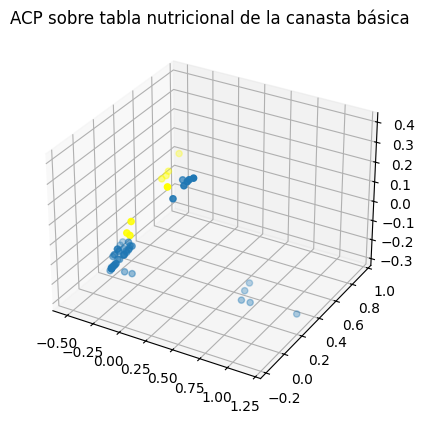

In [8]:
#
U, S, Vt = np.linalg.svd(tnCentrado)
V_reducido = Vt[:3,:]

tnProyecciones = np.dot(tnRestoCentrado,V_reducido.T)
tnFVProyecciones = np.dot(tnFVCentrado,V_reducido.T)
tnProtProyecciones = np.dot(tnProtCentrado,V_reducido.T)
tnSinProtProyecciones = np.dot(tnSinProtCentrado,V_reducido.T)
tnGrasosProyecciones = np.dot(tnGrasosCentrado,V_reducido.T)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(tnProyecciones[:,0],tnProyecciones[:,1],tnProyecciones[:,2])
#ax.scatter(tnFVProyecciones[:,0],tnFVProyecciones[:,1],tnFVProyecciones[:,2],color="green")
#ax.scatter(tnProtProyecciones[:,0],tnProtProyecciones[:,1],tnProtProyecciones[:,2],color="red")
#ax.scatter(tnSinProtProyecciones[:,0],tnSinProtProyecciones[:,1],tnSinProtProyecciones[:,2],color="orange")
ax.scatter(tnGrasosProyecciones[:,0],tnGrasosProyecciones[:,1],tnGrasosProyecciones[:,2],color="yellow")
ax.set_title("ACP sobre tabla nutricional de la canasta básica")
plt.show()

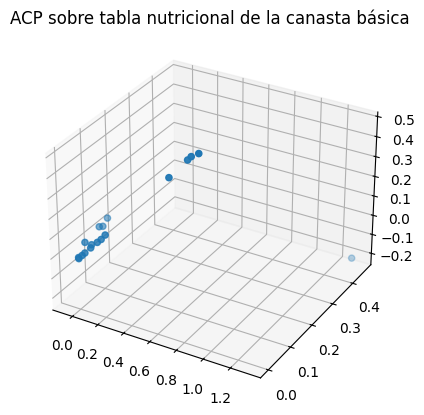

In [9]:
#Elementos de la tabla consumidores_libres
alim_cl = consumidores_libres["PRODUCTOS"].tolist()
#Reemplazo los nombres para que coincidan con los de la tabla nutricional
alim_cl[0] = "Leche fluida entera"
alim_cl[1] = "Arroz"
alim_cl[2] = "Azucar"
alim_cl[3] = "Fideos secos"
alim_cl[4] = "Harina trigo"
alim_cl[5] = "Huevo" #En el precio hace referencia a la docena y en la tabla nutricional a los 16 huevos, para pensar
alim_cl[6] = "Pan Frances"
alim_cl[7] = "Leche fluida entera"
alim_cl[8] = "Yerba"
alim_cl[9] = "Zanahoria"
alim_cl[10] = "Berenjena" #No hay berenjena en la tabla nutricional ???
alim_cl[11] = "Tomate"
alim_cl[12] = "Cebolla"
alim_cl[13] = "Papa"
alim_cl[14] = "Acelga"
alim_cl[15] = "Naranja"
alim_cl[16] = "Manzana"
alim_cl[17] = "Bola de Lomo"
alim_cl[18] = "Asado"
alim_cl[19] = "Paleta"
alim_cl[20] = "Carne picada"

#DataFrame con los datos nutricionales de los elementos de la tabla consumidores_libres
cl = tn0.loc[tn0['Alimento'].isin(alim_cl)]

#Matriz del DataFrame
cl = cl.values[:,2:]

proyec = np.dot(cl,V_reducido.T)

#Gráfico
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(proyec[:,0],proyec[:,1],proyec[:,2])
ax.set_title("ACP sobre tabla nutricional de la canasta básica")
plt.show()